In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import RotationNet.utils.image_utils as iu
import RotationNet.model.predict as predict
from RotationNet.model.train import SnapshotConfig
from PIL import Image


import os

import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [2]:
data = pd.read_csv("/scratch/gpfs/eh0560/RotationNet/evaluation_results/wandb_export_2023-12-06T11_41_43.724-05_00.csv")

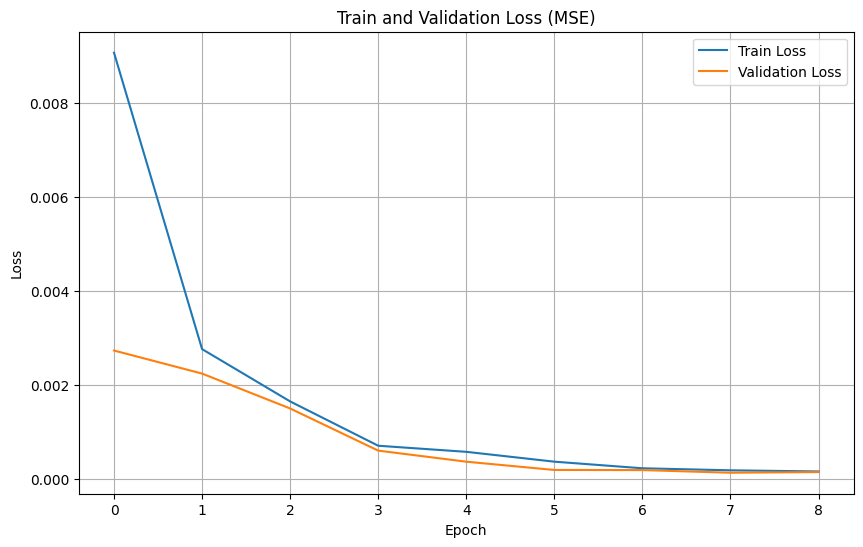

In [3]:
# Extracting relevant columns for plotting
steps = data["Step"]
train_loss = data["iconic-donkey-181 - train_loss"]
val_loss = data["iconic-donkey-181 - val_loss"]

# Plotting the train and test loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Train Loss")
plt.plot(steps, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
model_path = "/scratch/gpfs/eh0560/RotationNet/snapshots/MobileNetV3_1701860602_snapshot_best.pth"
model = predict.load_model(model_path)


In [5]:
image_annotations_file = "/scratch/gpfs/eh0560/datasets/deskewing/synthetic_data_angles_no_cudl.csv"
image_paths_directory = "/scratch/gpfs/eh0560/datasets/deskewing/synthetic_data/"
annotations = pd.read_csv(image_annotations_file)
image_paths = [os.path.join(image_paths_directory, image_path) for image_path in annotations["image_name"]]
true_angle_map = {image_path: angle for image_path, angle in zip(image_paths, annotations["document_angle"])}

In [6]:
def read_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    return image

In [7]:
image = read_image(image_paths[0])
angle = predict.predict_image(model, image)

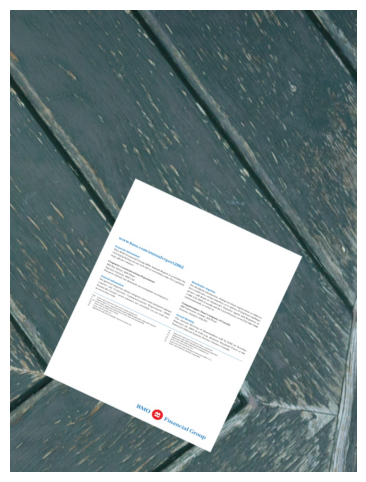

In [8]:
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

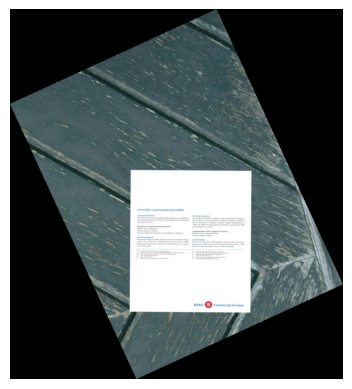

In [9]:
plt.imshow(iu.rotate_image(image, -angle))
plt.axis("off")
plt.show()

In [10]:
def predict_and_show(image_path):
    image = read_image(image_path)
    angle = predict.predict_image(model, image)
    rotated_image = iu.rotate_image(image, -angle)
    degrees = np.rad2deg(angle)
    plt.figure(figsize=(10, 7))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    ax.set_title("Original Image")
    ax = plt.subplot(1, 2, 2)
    plt.imshow(rotated_image)
    plt.axis("off")
    ax.set_title(f"Predicted Rotation ({degrees:.1f} degrees)")


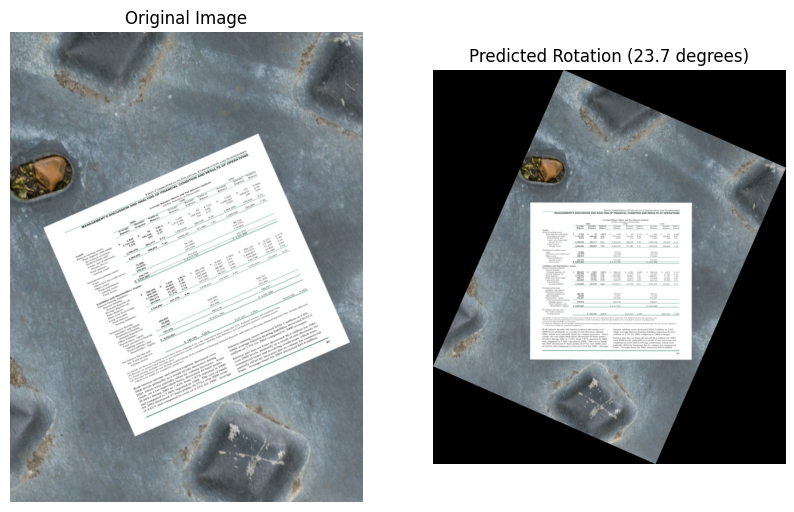

In [11]:
idx = np.random.randint(0, len(image_paths))
predict_and_show(image_paths[idx])

In [12]:
image_path_subset = image_paths[:1024]
images = [read_image(path) for path in image_path_subset]

In [13]:
predicted_angles = predict.batch_predict_images(model, images, batch_size=64)

torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])
torch.Size([64, 3, 1200, 900])


In [14]:
prediction_info = []
for image_path, angle in zip(image_path_subset, predicted_angles):
    true_angle = true_angle_map[image_path]
    info = {
        "image_path": image_path,
        "predicted_angle": angle,
        "true_angle": true_angle,
        "residual": angle - true_angle,
    }
    prediction_info.append(info)

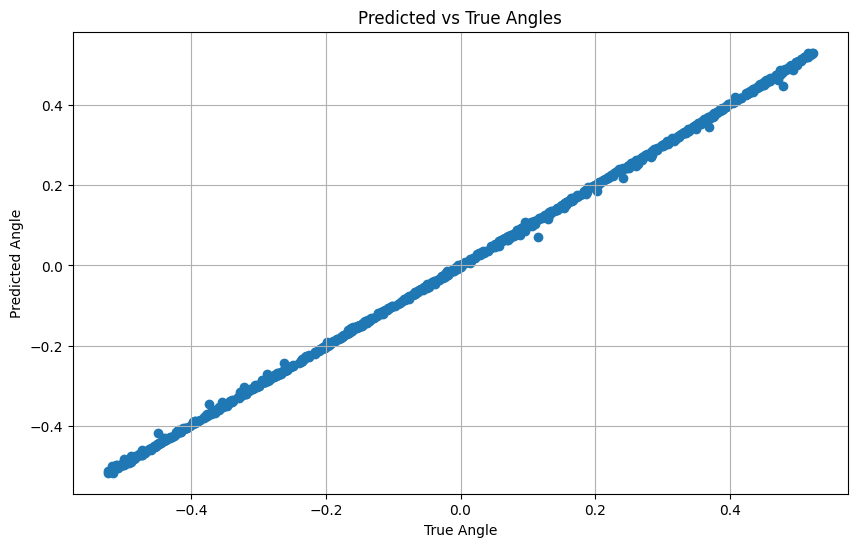

In [15]:
# scatter plot of predicted vs true angles
plt.figure(figsize=(10, 6))
plt.scatter([r["true_angle"] for r in prediction_info], [r["predicted_angle"] for r in prediction_info])
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.title("Predicted vs True Angles")
plt.grid(True)
plt.show()

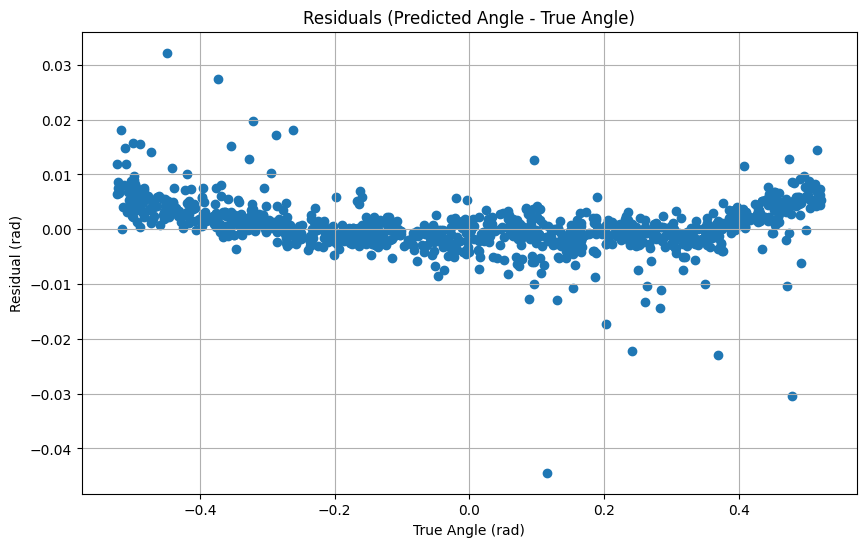

In [16]:
# scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter([r["true_angle"] for r in prediction_info], [r["residual"] for r in prediction_info])
plt.xlabel("True Angle (rad)")
plt.ylabel("Residual (rad)")
plt.title("Residuals (Predicted Angle - True Angle)")
plt.grid(True)
plt.show()


In [44]:
def get_feature_maps(model, image, layers):
    feature_maps = []
    x = image
    for name, layer in model._modules.items():
        print(layer)
        x = layer(x)
        print("---------------")
        # if name in layers:
            # feature_maps.append(x)
        feature_maps.append(x)
    return feature_maps

In [45]:
image = predict.create_image_batch([images[0]])
get_feature_maps(model, image, None)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Identity()
      (4): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU

RuntimeError: mat1 and mat2 shapes cannot be multiplied (960x1 and 960x1)

In [19]:
def visualize_feature_maps(feature_maps):
    square = 8
    for fmap in feature_maps:
        fmap = fmap.data.numpy()
        ix = 1
        for _ in range(square):
            for _ in range(square):
                ax = plt.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(fmap[0, ix - 1, :, :], cmap="gray")
                ix += 1
        plt.show()

In [20]:
model.children()

<generator object Module.children at 0x1466c0a24ac0>